# Projeto de Bloco: Inteligência Artificial e Machine Learning
## Teste de Performance - TP5

### Atividade 1
Criação das features: Computar o Term Frequency-Inverse Document Frequency (TF-IDF) para representar a importância das palavras em um conjunto de documentos.

### Atividade 2
Modelagem de Tópicos com LDA: Aplicar o algoritmo LDA para identificar tópicos prevalentes nos dados. A seleção do número de tópicos será baseada em métricas de coerência para garantir a relevância e a distinção entre os tópicos identificados.

### Atividade 3
Classificação de Textos: Desenvolver modelos de classificação para categorizar os textos com base nos tópicos identificados. Você pode escolher qualquer modelo aprendido ao longo do curso e deve escolher o melhor modelo usando as técnicas aprendidas, como busca de hiperparâmetros e validação cruzada

### Atividade 4
Avaliação de Desempenho: O desempenho dos modelos de classificação será avaliado utilizando métricas como precisão, recall, F1-score e AUC-ROC.

### Atividade 5
Visualização com t-SNE: Aplicar a técnica de t-SNE nos dados textuais vetorizados para reduzir a dimensionalidade e visualizar os agrupamentos de documentos de maneira intuitiva, facilitando a identificação de padrões e outliers.

### Atividade 6
Interpretação de Modelos com LIME, SHAP e Force-Plot: Utilizar SHAP para explicar as previsões individuais, identificando a contribuição de cada feature para a decisão do modelo. O force-plot será usado para visualizar essas contribuições de maneira agregada, oferecendo insights sobre a lógica de decisão do modelo.

### Atividade 7
Análise dos resultados: Enumere as conclusões que podem ser tomadas a partir dos resultados obtidos.


  palavra  média tfidf
0   movie     0.083537
1    film     0.073692
2    like     0.041061
3    just     0.038029
4    good     0.035787
5    time     0.030434
6   story     0.030422
7  really     0.029998
8     bad     0.027742
9   great     0.027300

Busca de hiperparâmetros para LDA:
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Melhores parâmetros encontrados: {'doc_topic_prior': 0.1, 'learning_decay': 0.7, 'n_components': 20, 'topic_word_prior': 0.1}

Palavras mais importantes para cada tópico (LDA):
Tópico 0: like good just hilarious laugh jokes fun humor comedy funny
Tópico 1: film doesn does hollywood guy big scene like mr just
Tópico 2: awful waste don seen time just acting worst bad movie
Tópico 3: television just like shows years time episodes episode tv series
Tópico 4: animation series like american new time world characters original story
Tópico 5: town girl woman father life wife young story film man
Tópico 6: woman looks bad scene monster scenes films s

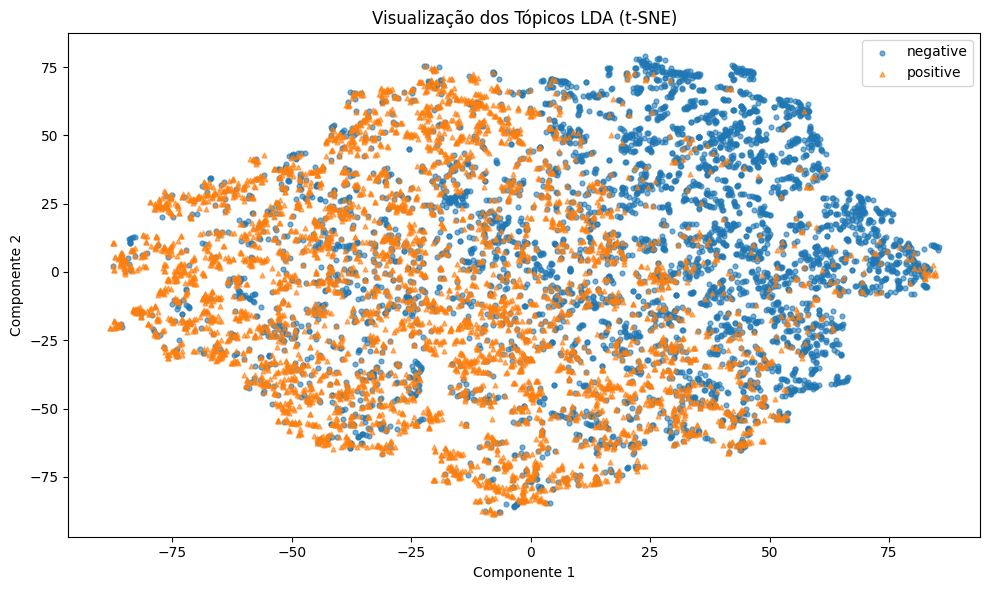

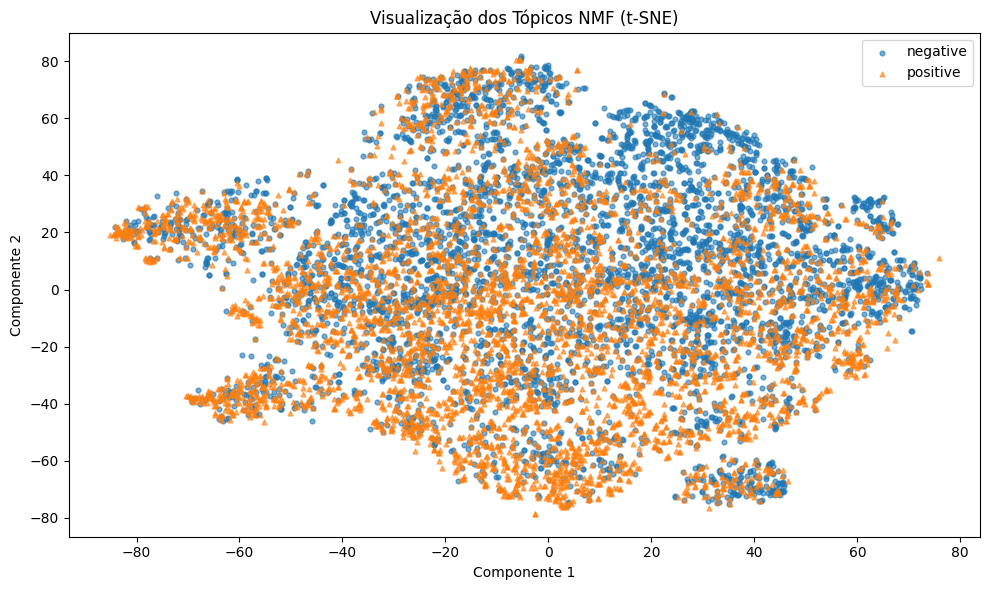

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

import warnings
warnings.filterwarnings("ignore")

# Importar o dataset de Reviews de Filmes do IMDB
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
imdb = pd.read_csv(path + "/IMDB Dataset.csv")


# --------------------------------------------------------------------------------
# Atividade 1
# --------------------------------------------------------------------------------

# O dataset possui quebras de linha (representadas por <br />) que devem ser removidas
# Serão removidas também as stopwords em inglês
custom_stopwords = list(ENGLISH_STOP_WORDS) + ["br"]

# Criar a matriz TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=custom_stopwords, lowercase=True)
tfidf_features = tfidf_vectorizer.fit_transform(imdb["review"])

# Constantes utilizadas nas atividades
TOP_N = 10
RANDOM_STATE = 11

# Exibir as TOP_N palavras com maior média de TF-IDF
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
words = tfidf_features.mean(axis=0).A1
top_idx = words.argsort()[::-1][:TOP_N]
top_words = pd.DataFrame({
    "palavra": feature_names[top_idx],
    "média tfidf": words[top_idx]
})
print(top_words)


# --------------------------------------------------------------------------------
# Atividade 2
# --------------------------------------------------------------------------------

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Identificar os tópicos prevalentes nos dados
# Como o LDA não utiliza TF-IDF, é necessário criar uma matriz de contagem de palavras
count_vectorizer = CountVectorizer(max_features=1000, stop_words=custom_stopwords, lowercase=True)
count_features = count_vectorizer.fit_transform(imdb["review"])

# Criar o modelo LDA com busca de hiperparâmetros e validação cruzada
print("\nBusca de hiperparâmetros para LDA:")
param_grid = {
    "n_components": [5, 10, 20],
    "learning_decay": [0.5, 0.7, 0.9],
    "doc_topic_prior": [None, 0.1, 0.5],
    "topic_word_prior": [None, 0.1, 0.5]
}
lda_model = LatentDirichletAllocation(random_state=RANDOM_STATE, n_jobs=-1)
lda_grid = GridSearchCV(estimator=lda_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
lda_grid.fit(count_features)
lda_features = lda_grid.best_estimator_.fit_transform(count_features)
print(f"Melhores parâmetros encontrados: {lda_grid.best_params_}")

# Exibir as palavras mais importantes para cada tópico
print("\nPalavras mais importantes para cada tópico (LDA):")
for i, topic in enumerate(lda_grid.best_estimator_.components_):
    print(f"Tópico {i}:", end=" ")
    print(" ".join([count_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-TOP_N:]]))


# --------------------------------------------------------------------------------
# Atividade 3
# --------------------------------------------------------------------------------
from sklearn.decomposition import NMF

# Criar o modelo NMF com busca de hiperparâmetros e validação cruzada
print("\nBusca de hiperparâmetros para NMF:")
param_grid = {
    "n_components": [5, 10, 20],
    "init": ["nndsvda", "nndsvdar"],
    "max_iter": [1000, 2000],
    "tol": [1e-3, 1e-2]
}
def nmf_reconstruction_scorer(estimator, X, y=None):
    return -estimator.reconstruction_err_
nmf_model = NMF(random_state=RANDOM_STATE)
nmf_grid = GridSearchCV(estimator=nmf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring=nmf_reconstruction_scorer)
nmf_grid.fit(tfidf_features)
nmf_features = nmf_grid.best_estimator_.fit_transform(tfidf_features)
print(f"Melhores parâmetros encontrados: {nmf_grid.best_params_}")

# Exibir as palavras mais importantes para cada tópico
print("\nPalavras mais importantes para cada tópico (NMF):")
for i, topic in enumerate(nmf_grid.best_estimator_.components_):
    print(f"Tópico {i}:", end=" ")
    print(" ".join([tfidf_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-TOP_N:]]))


# --------------------------------------------------------------------------------
# Atividade 4
# --------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Usatilizando os tópicos LDA para treinamento do modelo de classificação
# Dividir os dados em treino e teste, treinar o modelo SVM com kernel RBF e avaliar o desempenho
target = imdb["sentiment"].map({"positive": 1, "negative": 0})
feature_train_lda, feature_test_lda, label_train_lda, label_test_lda = train_test_split(lda_features, target, test_size=0.2, random_state=RANDOM_STATE)

# Treinar o modelo SVM com kernel RBF
svm_lda = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)
svm_lda.fit(feature_train_lda, label_train_lda)
target_pred_lda = svm_lda.predict(feature_test_lda)
target_prob_lda = svm_lda.predict_proba(feature_test_lda)[:, 1]

# Calcular as métricas de desempenho
accuracy_lda = accuracy_score(label_test_lda, target_pred_lda)
precision_lda = precision_score(label_test_lda, target_pred_lda)
recall_lda = recall_score(label_test_lda, target_pred_lda)
f1_lda = f1_score(label_test_lda, target_pred_lda)
roc_auc_lda = roc_auc_score(label_test_lda, target_prob_lda)

# Exibir os resultados
print("\nDesempenho do SVM com tópicos LDA:")
print(f"Acurácia: {accuracy_lda:.3f}")
print(f"Precisão: {precision_lda:.3f}")
print(f"Recall: {recall_lda:.3f}")
print(f"F1-Score: {f1_lda:.3f}")
print(f"ROC AUC: {roc_auc_lda:.3f}")

# Utilizando os tópicos NMF para treinamento do modelo de classificação
# Dividir os dados em treino e teste, treinar o modelo SVM com kernel RBF e avaliar o desempenho
target = imdb["sentiment"].map({"positive": 1, "negative": 0})
feature_train_nmf, feature_test_nmf, label_train_nmf, label_test_nmf = train_test_split(nmf_features, target, test_size=0.2, random_state=RANDOM_STATE)

# Treinar o modelo SVM com kernel RBF
svm_nmf = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)
svm_nmf.fit(feature_train_nmf, label_train_nmf)
target_pred_nmf = svm_nmf.predict(feature_test_nmf)
target_prob_nmf = svm_nmf.predict_proba(feature_test_nmf)[:, 1]

# Calcular as métricas de desempenho
accuracy_nmf = accuracy_score(label_test_nmf, target_pred_nmf)
precision_nmf = precision_score(label_test_nmf, target_pred_nmf)
recall_nmf = recall_score(label_test_nmf, target_pred_nmf)
f1_nmf = f1_score(label_test_nmf, target_pred_nmf)
roc_auc_nmf = roc_auc_score(label_test_nmf, target_prob_nmf)

# Exibir os resultados
print("\nDesempenho do SVM com tópicos NMF:")
print(f"Acurácia: {accuracy_nmf:.3f}")
print(f"Precisão: {precision_nmf:.3f}")
print(f"Recall: {recall_nmf:.3f}")
print(f"F1-Score: {f1_nmf:.3f}")
print(f"ROC AUC: {roc_auc_nmf:.3f}")

# --------------------------------------------------------------------------------
# Atividade 5
# --------------------------------------------------------------------------------

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduzir a dimensionalidade dos tópicos LDA para 2D usando t-SNE
tsne_lda = TSNE(n_components=2, random_state=RANDOM_STATE)
lda_2d = tsne_lda.fit_transform(feature_test_lda)

# Visualizar os tópicos LDA em 2D
plt.figure(figsize=(10, 6))
for cls, marker, name in [(0, "o", "negative"), (1, "^", "positive")]:
    idx = (label_test_lda == cls)
    plt.scatter(lda_2d[idx, 0], lda_2d[idx, 1], s=12, marker=marker, alpha=0.6, label=name)
plt.title("Visualização dos Tópicos LDA (t-SNE)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.tight_layout()
plt.show()

# Reduzir a dimensionalidade dos tópicos NMF para 2D usando t-SNE
tsne_nmf = TSNE(n_components=2, random_state=RANDOM_STATE)
nmf_2d = tsne_nmf.fit_transform(feature_test_nmf)

# Visualizar os tópicos NMF em 2D
plt.figure(figsize=(10, 6))
for cls, marker, name in [(0, "o", "negative"), (1, "^", "positive")]:
    idx = (label_test_nmf == cls)
    plt.scatter(nmf_2d[idx, 0], nmf_2d[idx, 1], s=12, marker=marker, alpha=0.6, label=name)
plt.title("Visualização dos Tópicos NMF (t-SNE)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.tight_layout()
plt.show()